In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import fmnist
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [112]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [113]:
train_loader, test_loader = fmnist()

In [114]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 125)
        self.fc4 = nn.Linear(125, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(500)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        if self.batchnorm:
            x = self.bn(x)
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [115]:
model = Net(False, False).to(device)

In [116]:
def train(epoch, model):
    
    print('Training epoch: {}\n'.format(epoch))
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        model.optim.zero_grad()
        output = model(data)
        loss = model.loss(output, target)
        loss.backward()
        model.optim.step()

In [117]:
def test(model, loader, dataset='test'):
    test_size = len(loader.sampler)
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += model.loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    test_loss /= test_size
    
    if dataset == 'train':
        train_losses.append(test_loss)
    else:
        test_losses.append(test_loss)
    
    print(f'{dataset.capitalize()} loss {test_loss}\t{dataset.capitalize()} accuracy {correct/test_size:.4f}\n')

In [118]:
train_losses = []
test_losses = []

for epoch in range(1, 31):
    model.train()
    train(epoch, model)
    model.eval()
    test(model, train_loader, 'train')
    test(model, test_loader)

Training epoch: 1

Train loss 0.4114426838239034	Train accuracy 0.8531

Test loss 0.4466184823036194	Test accuracy 0.8401

Training epoch: 2

Train loss 0.35132409792741137	Train accuracy 0.8744

Test loss 0.40001661195755006	Test accuracy 0.8571

Training epoch: 3

Train loss 0.3169222644408544	Train accuracy 0.8851

Test loss 0.3711902168750763	Test accuracy 0.8665

Training epoch: 4

Train loss 0.312683242503802	Train accuracy 0.8849

Test loss 0.3765928560256958	Test accuracy 0.8654

Training epoch: 5

Train loss 0.2817715433518092	Train accuracy 0.8950

Test loss 0.3517395163536072	Test accuracy 0.8718

Training epoch: 6

Train loss 0.2624332334200541	Train accuracy 0.9022

Test loss 0.34717411692142486	Test accuracy 0.8748

Training epoch: 7

Train loss 0.24284134073257446	Train accuracy 0.9090

Test loss 0.3321710046291351	Test accuracy 0.8797

Training epoch: 8

Train loss 0.23726425282557806	Train accuracy 0.9127

Test loss 0.33137539553642276	Test accuracy 0.8808

Training ep

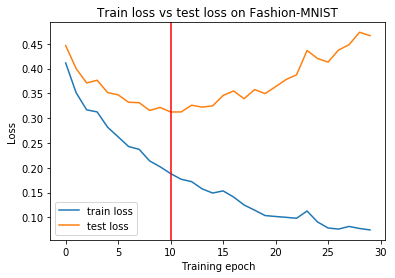

In [130]:
plt.plot(range(len(train_losses)), train_losses, label='train loss')
plt.plot(range(len(test_losses)), test_losses, label='test loss')
plt.axvline(x=np.argmin(test_losses), color='r', linestyle='-')
plt.xlabel('Training epoch')
plt.ylabel('Loss')
plt.title('Train loss vs test loss on Fashion-MNIST')
plt.legend();